# README
The aim of this notebook is to build a Black-Scholes class to explain theoretical questions I have about options. In particular, I want to especially explore how an option's P&L is affected by realised vs implied volatility. This paper by Paul Wilmott dives into the details: http://spekulant.com.pl/article/Delta%20Hedging/Which%20Free%20Lunch%20Would%20You%20Like%20TodaySir%20DeltaHedgingVolatility.pdf

This info can ultimately be used in a trading strategy on QuantConnect.

# Imports

In [1]:
import math
from scipy.stats import norm
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from matplotlib.cm import get_cmap

# Black-Scholes Class

TODO: Write markdown deriving the Black-Scholes equation and formula. Also write markdown to explain derivation of the formulas for the Greeks

In [2]:
class BlackScholesModel:
    """
    Class to model options using the Black-Scholes model.
    """

    def __init__(
        self
    ) -> None:
        """
        Constructor
        """
    ############################
    # Pricing and implied vol
    ############################
    
    def d1_and_d2(
        self,  
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> tuple:
        """
        Function to calculate the tuple (d1, d2) in the Black-Scholes formula
        """
        # Calculate d1
        numerator_first = math.log(S / K)
        numerator_second = t * (r + (0.5 * (sigma ** 2)))
        denominator = sigma * math.sqrt(t)
        d1 = (numerator_first + numerator_second) / denominator

        # Calculate d2
        d2 = d1 - denominator

        return d1, d2
    
    def price(
        self,
        option_type,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the price of an option as in the Black-Scholes formula
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate price
        if option_type == 'C':
            first_term = S * norm.cdf(d1)
            second_term = K * math.exp(-r * t) * norm.cdf(d2)
            value = first_term - second_term
        elif option_type == 'P':
            first_term = K * math.exp(-r * t) * norm.cdf(-d2)
            second_term = S * norm.cdf(-d1)
            value = first_term - second_term
        else:
            raise ValueError("Invalid option_type. Must be 'C' or 'P'")

        return value

    def implied_vol(
        self,
        option_type: str,
        option_price: float,
        S: float,
        K: float,
        r: float,
        t: float
    ) -> float:
        """
        Function to numerically solve for the implied volatility of an option using its price.
        This is done by a minimization problem to minimize the difference between the price of 
        the option and the Black-Scholes price with implied vol as a variable.
        """
        # Cost function (least squares diff between option price and BS price)
        def cost_function(sigma):
            bs_price = self.price( 
                option_type=option_type,
                S=S,
                K=K,
                r=r,
                sigma=sigma,
                t=t
            )
            return (bs_price - option_price) ** 2

        # Solve for implied vol
        iv = minimize(
            fun=cost_function, 
            x0=0.2, 
            bounds=[(0.000001, 1000)], 
            method='L-BFGS-B', 
            tol=1e-6
        )
        
        return iv.x[0]
    
    ############################
    # Greeks
    ############################
    
    def delta(
        self,
        option_type,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the delta of an option derived from the Black-Scholes formula. 
        Delta measures the sensitivity of an option's price to a change in price of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate delta
        if option_type == 'C':
            value = norm.cdf(d1)
        elif option_type == 'P':
            value = norm.cdf(d1) - 1
        else:
            raise ValueError("Invalid option_type. Must be 'C' or 'P'")

        return value
    
    def gamma(
        self,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the gamma of an option derived from the Black-Scholes formula. 
        Gamma measures the sensitivity of an option's delta to a change in price of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate gamma
        value = norm.pdf(d1) / (S * sigma * math.sqrt(t))

        return value
    
    def vega(
        self,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the vega of an option derived from the Black-Scholes formula. 
        Vega measures the sensitivity of an option's price to a change in the volatility of the underlying.
        """
        # Calculate d1 and d2 (only need d1)
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate vega
        value = S * norm.pdf(d1) * math.sqrt(t)

        return value

    def theta(
        self,
        option_type,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the theta of an option derived from the Black-Scholes formula. 
        Theta measures the sensitivity of an option's price to a change in the time to expiry.
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate terms needed for theta
        first_term = S * norm.pdf(d1) * sigma / (2 * math.sqrt(t))
        second_term_common_factor = r * K * math.exp(-r * t)
        
        # Calculate theta
        if option_type == 'C':
            value = -first_term - (second_term_common_factor * norm.cdf(d2)) 
        elif option_type == 'P':
            value = -first_term + (second_term_common_factor * norm.cdf(-d2)) 
        else:
            raise ValueError("Invalid option_type. Must be 'C' or 'P'")

        return value

    def rho(
        self,
        option_type,
        S: float,
        K: float,
        r: float,
        sigma: float,
        t: float
    ) -> float:
        """
        Function to return the rho of an option derived from the Black-Scholes formula. 
        Rho measures the sensitivity of an option's price to a change in the risk-free interest rate.
        """
        # Calculate d1 and d2
        d1, d2 = self.d1_and_d2(
            S=S,
            K=K,
            r=r,
            sigma=sigma,
            t=t
        )

        # Calculate rho
        if option_type == 'C':
            value = K * t * math.exp(-r * t) * norm.cdf(d2)
        elif option_type == 'P':
            value = -K * t * math.exp(-r * t) * norm.cdf(-d2)
        else:
            raise ValueError("Invalid option_type. Must be 'C' or 'P'")

        return value

    ############################
    # Simulations
    ############################

    def simulate_gbm(
        self, 
        n_steps: int,
        S_0: float,
        t: float,
        mu: float,
        sigma: float
    ) -> np.ndarray:
        """
        Function to simulate Geometric Brownian Motion of the underlying asset, returning the price path taken by the underlying asset as an array.
        """
        # Calculate time increment
        dt = t / n_steps
        
        # Initialise path array
        path = np.zeros(n_steps + 1)
        path[0] = S_0
        
        # Use discrete form of Geometric Brownian Motion SDE to generate the path
        for step in range(1, n_steps + 1):
            z = np.random.standard_normal()
            path[step] = path[step - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
        
        return path


In [3]:
option_type = 'C'
S = 200
K = 200
r = 0.02
sigma = 0.20
t = 1

In [4]:
bsm = BlackScholesModel()

In [5]:
bsm.price(
    option_type=option_type,
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

17.832074557145077

In [6]:
bsm.delta(
    option_type=option_type,
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

0.579259709439103

In [7]:
bsm.gamma(
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

0.009776067349386398

In [8]:
bsm.vega(
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

78.20853879509117

In [9]:
bsm.theta(
    option_type=option_type,
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

-9.781251226122627

In [10]:
bsm.rho(
    option_type=option_type,
    S=S,
    K=K,
    r=r,
    sigma=sigma,
    t=t
)

98.01986733067552

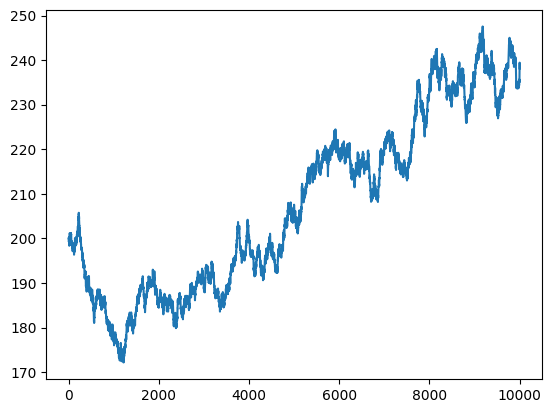

In [11]:
path = bsm.simulate_gbm(
    n_steps=10000,
    S_0=S,
    t=t,
    mu=r,
    sigma=sigma
)
plt.plot(path)

In [12]:
bsm.implied_vol(
    option_type=option_type,
    option_price=20.269,
    S=S,
    K=K,
    r=r,
    t=t
)

0.23116385581534557

# Exploring Greeks

### Delta and Gamma

In [13]:
# Generate range of underlying prices
underlying_prices = np.linspace(K-100, K+100, 100)

# Generate range of expiries
expiries = [1/365, 1/12, 1/4, 1/2, 1]

# Generate range of IVs
ivs = np.linspace(0.05, 0.4, 8)

In [14]:
# For each expiry, calculate delta at each spot price
deltas_per_expiry = [
    [
        bsm.delta(
            option_type='C',
            S=p,
            K=K,
            r=r,
            sigma=sigma,
            t=e
        ) 
        for p in underlying_prices
    ]
    for e in expiries
]

# For each IV, calculate delta at each spot price
deltas_per_iv = [
    [
        bsm.delta(
            option_type='C',
            S=p,
            K=K,
            r=r,
            sigma=iv,
            t=t
        ) 
        for p in underlying_prices
    ]
    for iv in ivs
]

# For each expiry, calculate gamma at each spot price
gammas_per_expiry = [
    [
        bsm.gamma(
            S=p,
            K=K,
            r=r,
            sigma=sigma,
            t=e
        ) 
        for p in underlying_prices
    ]
    for e in expiries
]

# For each IV, calculate gamma at each spot price
gammas_per_iv = [
    [
        bsm.gamma(
            S=p,
            K=K,
            r=r,
            sigma=iv,
            t=t
        ) 
        for p in underlying_prices
    ]
    for iv in ivs
]

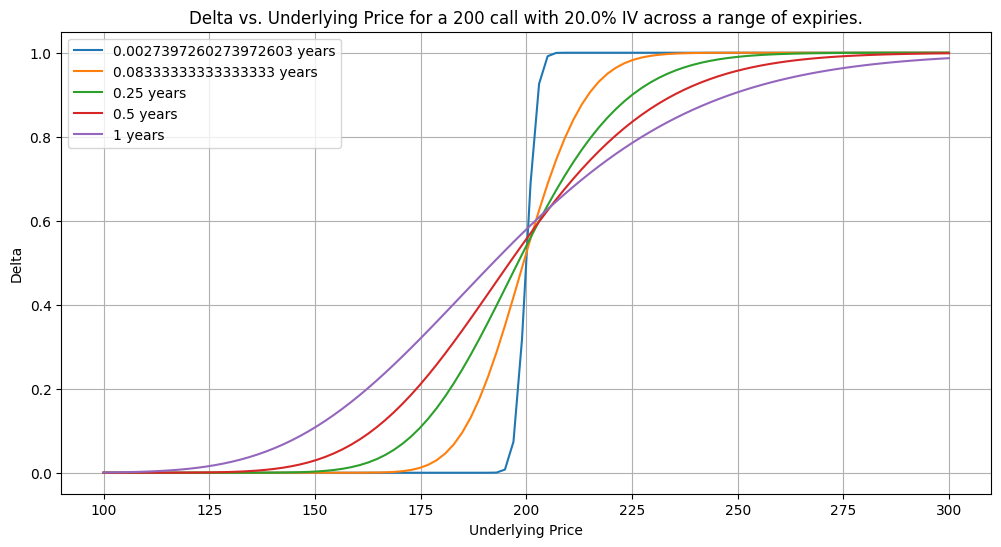

In [15]:
# Delta vs Spot for range of expiries
plt.figure(figsize=(12, 6))
for deltas, expiry in zip(deltas_per_expiry, expiries):
    plt.plot(underlying_prices, deltas, label=f'{expiry} years')
plt.xlabel('Underlying Price')
plt.ylabel('Delta')
plt.title(f'Delta vs. Underlying Price for a {K} call with {100 * sigma:.1f}% IV across a range of expiries.')
plt.legend()
plt.grid(True)
plt.show()

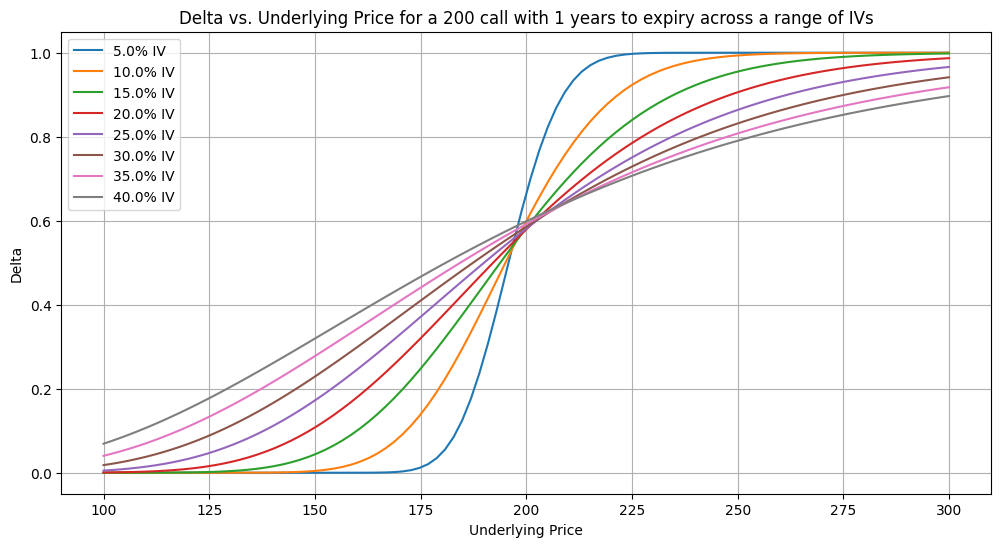

In [16]:
# Delta vs Spot for range of IVs
plt.figure(figsize=(12, 6))
for deltas, iv in zip(deltas_per_iv, ivs):
    plt.plot(underlying_prices, deltas, label=f'{iv * 100:.1f}% IV')
plt.xlabel('Underlying Price')
plt.ylabel('Delta')
plt.title(f'Delta vs. Underlying Price for a {K} call with {t} years to expiry across a range of IVs')
plt.legend()
plt.grid(True)
plt.show()

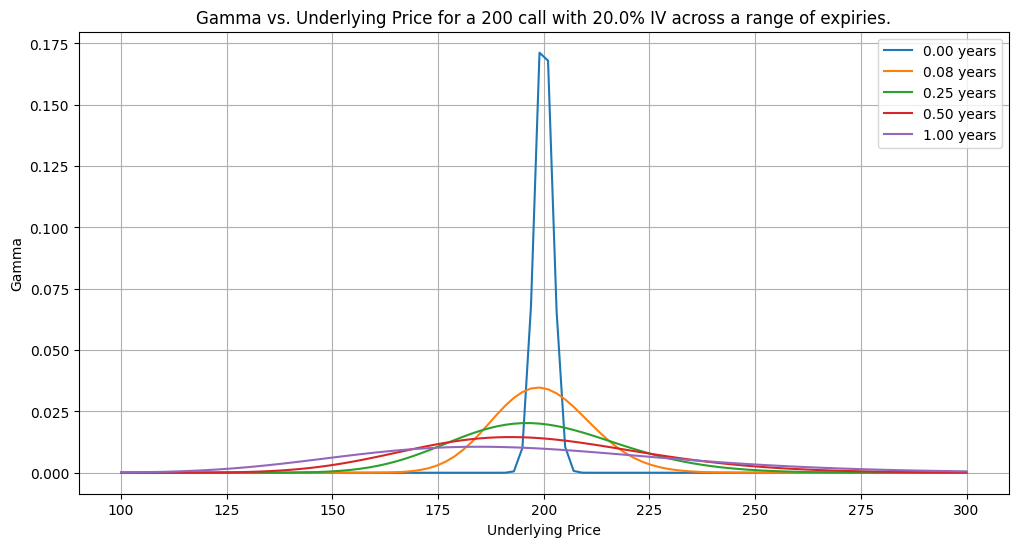

In [17]:
# Gamma vs Spot for range of expiries
plt.figure(figsize=(12, 6))
for gammas, expiry in zip(gammas_per_expiry, expiries):
    plt.plot(underlying_prices, gammas, label=f'{expiry:.2f} years')
plt.xlabel('Underlying Price')
plt.ylabel('Gamma')
plt.title(f'Gamma vs. Underlying Price for a {K} call with {100 * sigma:.1f}% IV across a range of expiries.')
plt.legend()
plt.grid(True)
plt.show()

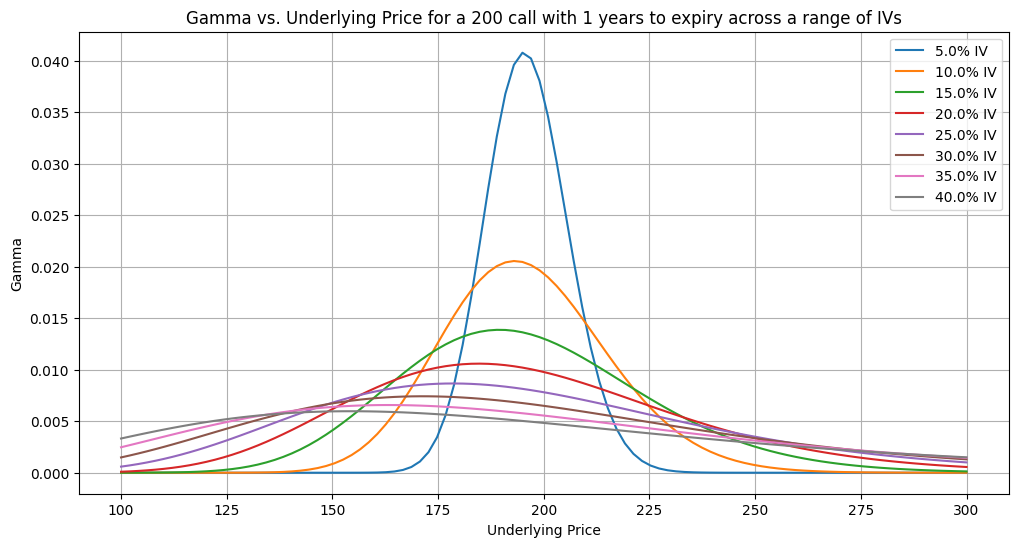

In [18]:
# Gamma vs Spot for range of IVs
plt.figure(figsize=(12, 6))
for gammas, iv in zip(gammas_per_iv, ivs):
    plt.plot(underlying_prices, gammas, label=f'{iv * 100:.1f}% IV')
plt.xlabel('Underlying Price')
plt.ylabel('Gamma')
plt.title(f'Gamma vs. Underlying Price for a {K} call with {t} years to expiry across a range of IVs')
plt.legend()
plt.grid(True)
plt.show()

### Theta

In [19]:
# Expiries for theta plots
expiries = np.linspace(0.01, 5, 200) 

# OTM, ATM, ITM spot prices for theta plots
spots = np.array([K-30, K, K+30])

In [20]:
# For each spot price, calculate theta at each expiry
thetas_per_spot = [
    [
        bsm.theta(
            option_type=option_type,
            S=spot,
            K=K,
            r=r,
            sigma=sigma,
            t=exp
        ) 
        for exp in expiries
    ]
    for spot in spots
]

# For each spot price, calculate theta at each expiry (but with a different IV to compare)
new_iv = sigma + 0.1
thetas_per_spot_new_iv = [
    [
        bsm.theta(
            option_type=option_type,
            S=spot,
            K=K,
            r=r,
            sigma=new_iv,
            t=exp
        ) 
        for exp in expiries
    ]
    for spot in spots
]

# Fixing everything else, calculate theta and gamma for a range of expries to show how they oppose each other
theta_by_expiry = [
    bsm.theta(
        option_type=option_type,
        S=S,
        K=K,
        r=r,
        sigma=sigma,
        t=exp
    ) 
    for exp in expiries
]
gamma_by_expiry = [
    bsm.gamma(
        S=S,
        K=K,
        r=r,
        sigma=sigma,
        t=exp
    ) 
    for exp in expiries
]

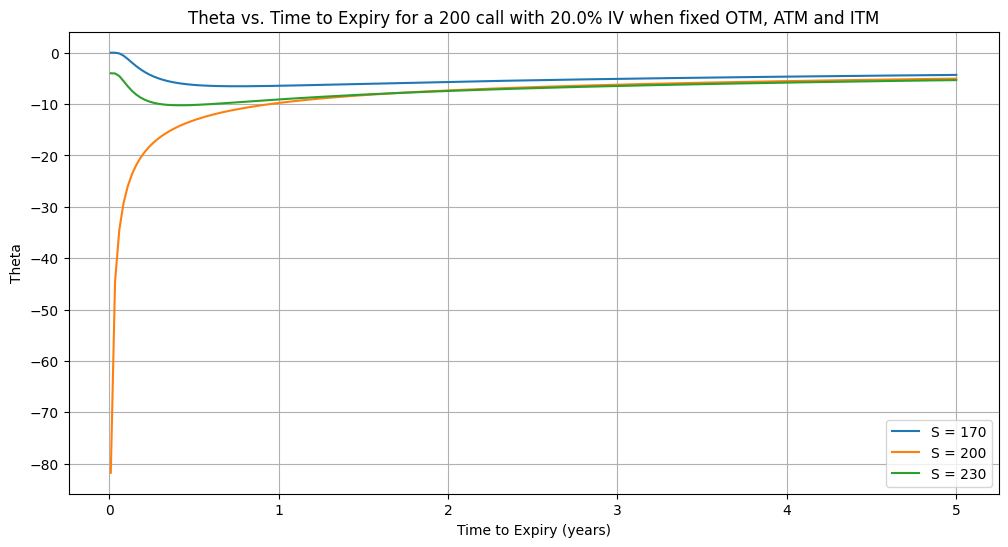

In [21]:
# Theta vs Expiry for range of spots
plt.figure(figsize=(12, 6))
for thetas, spot in zip(thetas_per_spot, spots):
    plt.plot(expiries, thetas, label=f'S = {spot}')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Theta')
plt.title(f'Theta vs. Time to Expiry for a {K} call with {100 * (sigma):.1f}% IV when fixed OTM, ATM and ITM')
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-22-503ee9a098c3>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


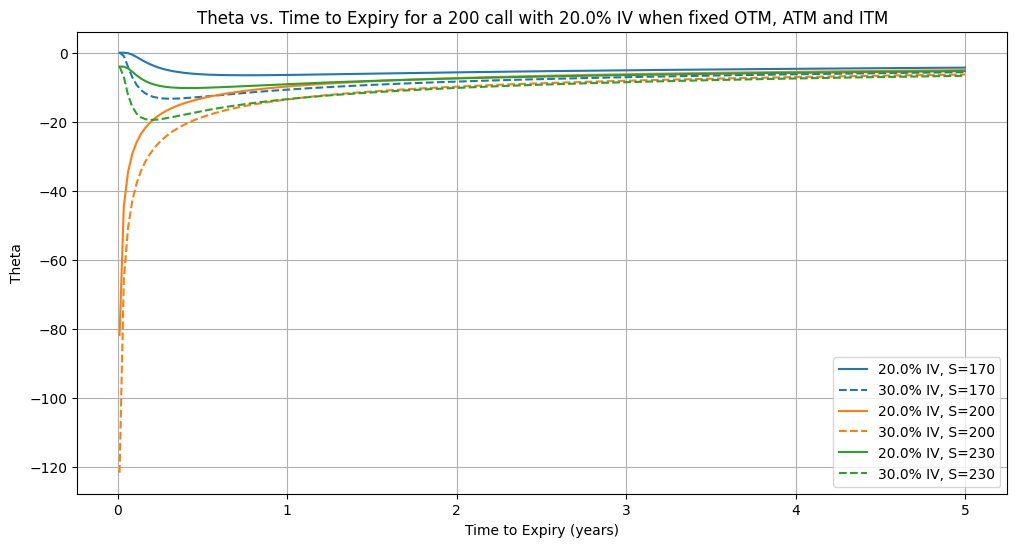

In [22]:
# Theta vs Expiry for range of spots for 2 different IVs
plt.figure(figsize=(12, 6))
cmap = get_cmap('tab10')
for i, (thetas_iv1, thetas_iv2, spot) in enumerate(zip(thetas_per_spot, thetas_per_spot_new_iv, spots)):
    color = cmap(i % 10) 
    plt.plot(expiries, thetas_iv1, label=f'{100*sigma:.1f}% IV, S={spot}', color=color)
    plt.plot(expiries, thetas_iv2, label=f'{100*new_iv:.1f}% IV, S={spot}', color=color, linestyle='dashed')
plt.xlabel('Time to Expiry (years)')
plt.ylabel('Theta')
plt.title(f'Theta vs. Time to Expiry for a {K} call with {100 * (sigma)}% IV when fixed OTM, ATM and ITM')
plt.legend()
plt.grid(True)
plt.show()

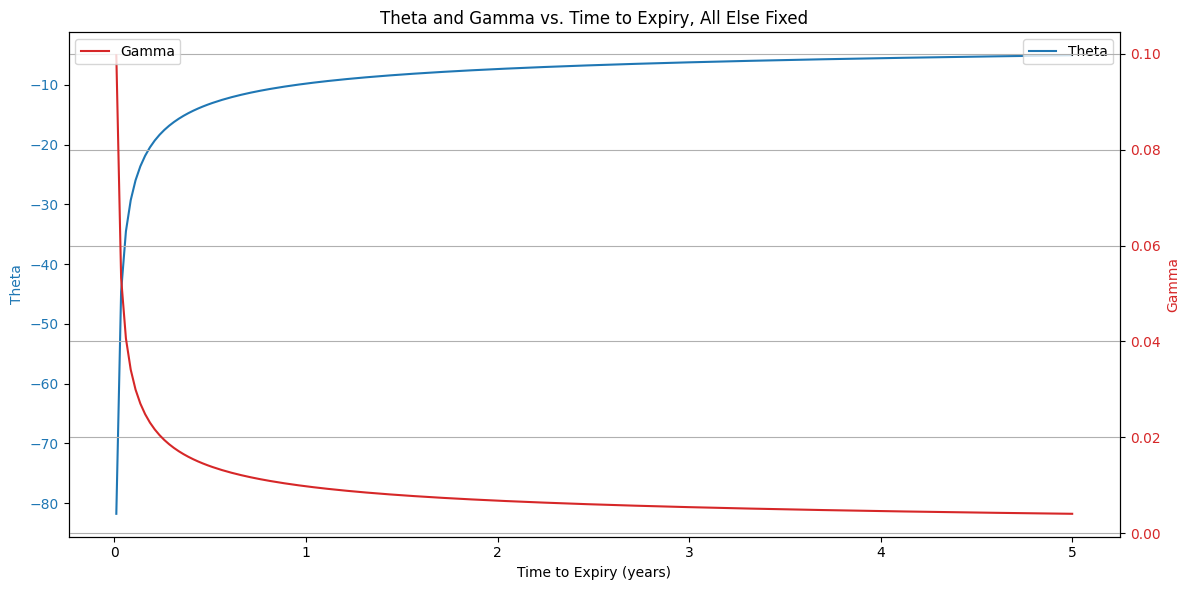

In [23]:
# Plot theta and gamma vs time to expiry to show their opposing relationship
fig, ax1 = plt.subplots(figsize=(12, 6))
color = 'tab:blue'
ax1.set_xlabel('Time to Expiry (years)')
ax1.set_ylabel('Theta', color=color)
ax1.plot(expiries, theta_by_expiry, label='Theta', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Gamma', color=color)
ax2.plot(expiries, gamma_by_expiry, label='Gamma', color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.title('Theta and Gamma vs. Time to Expiry, All Else Fixed')
fig.tight_layout()
plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()

In [24]:
# TODO: start adding descriptions/markdown in the notebook to explain what's going on.